# Read MYD35_L2, MYD06_L2 and LID_L2_05km_MLay products and identify the relevant properties

## Read MYD06 file and plot cloud phase

109620


/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


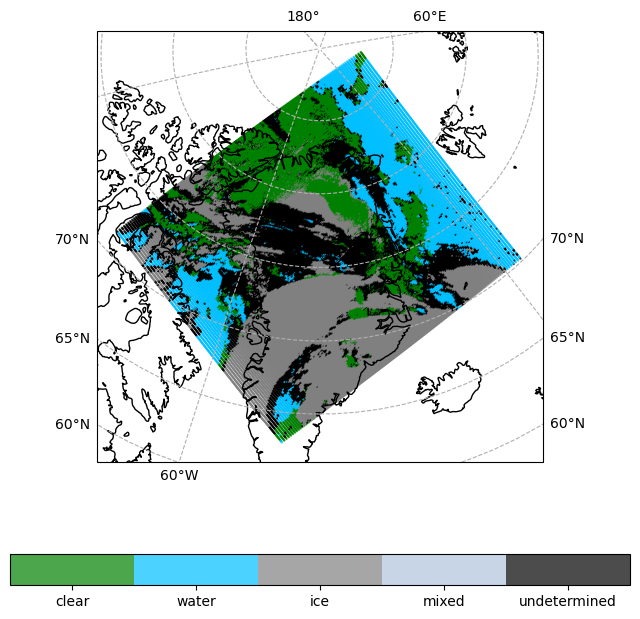

In [176]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()

modis_cloud_phase_day = MODIS_reader.select("Cloud_Phase_Infrared_Day").get()
modis_cloud_phase_night = MODIS_reader.select("Cloud_Phase_Infrared_Day").get()
invalid_data_mask_day = modis_cloud_phase_day > 6
invalid_data_mask_night = modis_cloud_phase_night > 6

modis_cloud_phase_day = np.ma.array(modis_cloud_phase_day, mask=invalid_data_mask_day)
modis_cloud_phase_night = np.ma.array(modis_cloud_phase_night, mask=invalid_data_mask_night)

invalid_data_mask = modis_cloud_phase > 6
modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_phase = np.ma.array(modis_cloud_phase, mask=invalid_data_mask)

print(np.size(modis_cloud_phase))


def byte_to_label(byte):
    if byte == 6:
        return 5.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

colormap = ListedColormap(['green', 'deepskyblue', 'grey', 'lightsteelblue', 'black'])

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=2, cmap=colormap, transform=ccrs.PlateCarree(), alpha=0.7)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 6))

cbar.set_ticklabels(['clear','water','ice','mixed', 'undetermined'])


## Read MYD06 data and plot cloud fractions

array([[<Axes: title={'center': 'frac'}>]], dtype=object)

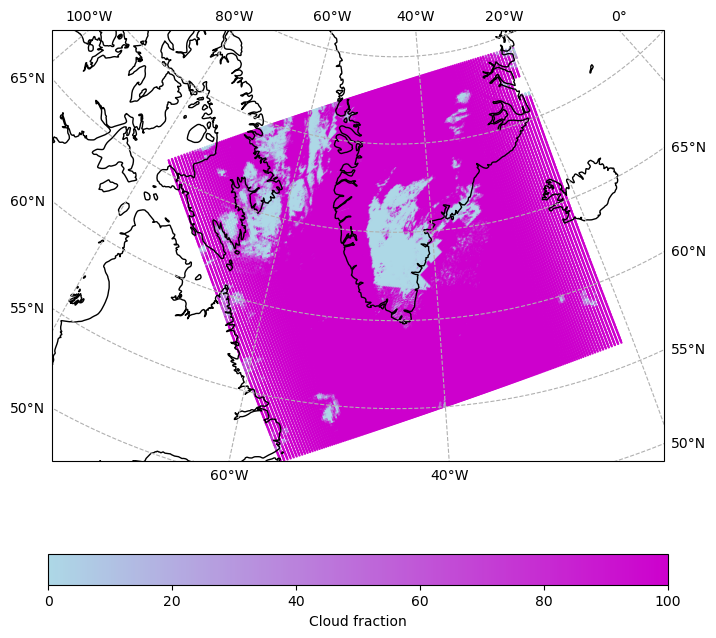

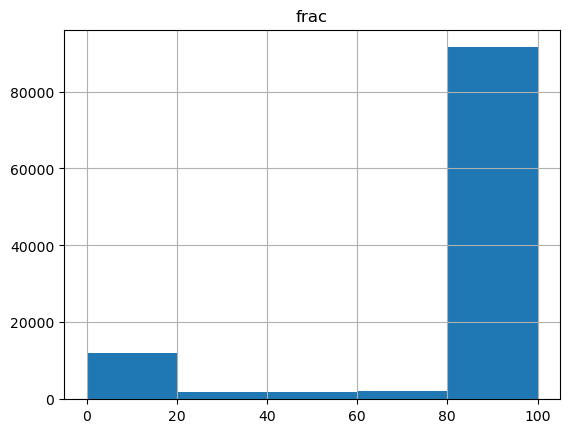

In [133]:
modis_cloud_fraction = MODIS_reader.select("Cloud_Fraction").get()
invalid_data_mask = modis_cloud_fraction > 100

modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_fraction = np.ma.array(modis_cloud_fraction, mask=invalid_data_mask)


def create_skyblue_to_transparent_cmap():
    # Define the colors
    colors = [(173/255, 216/255, 230/255, 1), (205/255, 0/255, 205/255, 1)]

    # Create the colormap
    cmap = LinearSegmentedColormap.from_list("lightblue_to_grey", colors)

    return cmap

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=modis_cloud_fraction, marker='.', s=2, transform=ccrs.PlateCarree(),
                 cmap=create_skyblue_to_transparent_cmap())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", label="Cloud fraction")

import pandas as pd
df = pd.DataFrame(np.array(modis_cloud_fraction).flatten(), columns=["frac"])
df = df[df.frac < 101]
df.hist(bins=5)


## Read MYD06 data and plot cloud mask

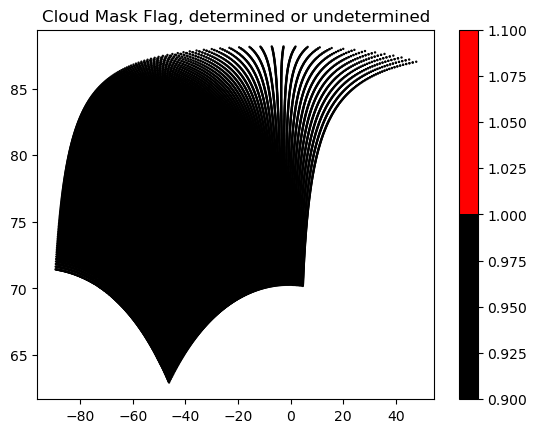

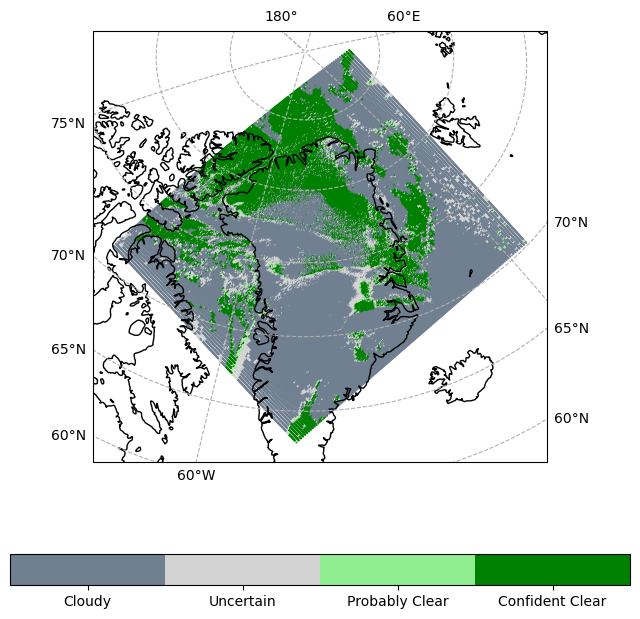

In [174]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_mask_5km = MODIS_reader.select("Cloud_Mask_5km").get()[:,:,0]

# the following section is almost entirely written using ChatGPT

def vectorized_parse_byte_properties(byte_array):
    # Vectorized version of parse_byte_properties function
    properties = {}

    # Bit 0: Cloud Mask Flag
    properties['Cloud Mask Flag'] = np.where((byte_array & 0b1) == 0, 'Not determined', 'Determined')

    # Bits 2-1: Unobstructed FOV Quality Flag
    quality_flag = (byte_array >> 1) & 0b11
    quality_mapping = {
        0b00: 'Cloudy',
        0b01: 'Uncertain',
        0b10: 'Probably Clear',
        0b11: 'Confident Clear'
    }
    properties['Unobstructed FOV Quality Flag'] = np.vectorize(quality_mapping.get)(quality_flag)

    # Bit 3: Day or Night Path
    properties['Day or Night Path'] = np.where((byte_array >> 2) & 0b1 == 0, 'Night', 'Day')

    # Bit 4: Sunglint Path
    properties['Sunglint Path'] = np.where((byte_array >> 3) & 0b1 == 0, 'Yes', 'No')

    # Bit 5: Snow/Ice Background Path
    properties['Snow/Ice Background Path'] = np.where((byte_array >> 4) & 0b1 == 0, 'Yes', 'No')

    # Bits 7-6: Land or Water Path
    land_water_flag = (byte_array >> 5) & 0b11
    land_water_mapping = {
        0b00: 'Water',
        0b01: 'Coastal',
        0b10: 'Desert',
        0b11: 'Land'
    }
    properties['Land or Water Path'] = np.vectorize(land_water_mapping.get)(land_water_flag)

    return properties

# Example usage with a NumPy array of bytes
byte_array = np.array(modis_cloud_mask_5km, dtype=np.uint8).flatten()
result = vectorized_parse_byte_properties(byte_array)

# Map colors to property values
color_mapping = {
    'Cloudy': 0,
    'Uncertain': 1,
    'Probably Clear': 2,
    'Confident Clear': 4
}

# Extract Unobstructed FOV Quality Flag data
quality_flag_data = result['Unobstructed FOV Quality Flag']
color_matrix = np.vectorize(color_mapping.get)(quality_flag_data)
colormap = ListedColormap(['slategrey', 'lightgrey', 'lightgreen', 'green'])

# check if there are undetermined cloud mask pixels
plt.scatter(modis_long, modis_lat, marker='.', s=2, c=np.where(result["Cloud Mask Flag"] == "Determined", 1, 0), cmap=ListedColormap(["black", "red"]))
plt.colorbar()
plt.gca().set_title("Cloud Mask Flag, determined or undetermined")

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
# ccrs_projection = ccrs.NorthPolarStereo()
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent((np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)), ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
pos = ax.scatter(modis_long, modis_lat, c=color_matrix, marker='.', s=2, transform=ccrs.PlateCarree(), cmap=colormap)
cbar = fig.colorbar(pos, ticks=[0.5, 1.5, 2.5, 3.5], location="bottom")
cbar.set_ticklabels(['Cloudy', 'Uncertain', 'Probably Clear', 'Confident Clear'])

# Use collocation database to load CALIOP and MODIS products

## Select date and load collocation csv

In [2]:
import pandas as pd
import os
import datetime

path_to_collocation_database = "./collocation_database/"
selected_date = datetime.datetime(year=2017, month=1, day=1)

def select_CALIOP_file_by_day(path_to_month_folder, day):
    import glob

    search_pattern = f"*-{day:02d}T*"
    return glob.glob(search_pattern, root_dir=path_to_month_folder)

path_to_collocation_month = os.path.join(path_to_collocation_database, selected_date.strftime("%Y/%m"))

selected_CALIOP_file_list = select_CALIOP_file_by_day(path_to_collocation_month, selected_date.day)

collocated_dfs = {}

for file in selected_CALIOP_file_list:
    collocated_dfs[file[0:-4]] = pd.read_csv(os.path.join(path_to_collocation_month, file))
    display(collocated_dfs[file[0:-4]].MODIS_file.describe())

count                                              257
unique                                               1
top       MYD35_L2.A2017001.1350.061.2018029021044.hdf
freq                                               257
Name: MODIS_file, dtype: object

count                                              130
unique                                               2
top       MYD35_L2.A2017001.1530.061.2018029020435.hdf
freq                                               124
Name: MODIS_file, dtype: object

count                                              250
unique                                               1
top       MYD35_L2.A2017001.1525.061.2018029020525.hdf
freq                                               250
Name: MODIS_file, dtype: object

count                                              257
unique                                               1
top       MYD35_L2.A2017001.1350.061.2018029021044.hdf
freq                                               257
Name: MODIS_file, dtype: object

## Understand CALIOP layer data

./test_data/CALIOP/2017/01/CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN.hdf
(15, 3728)


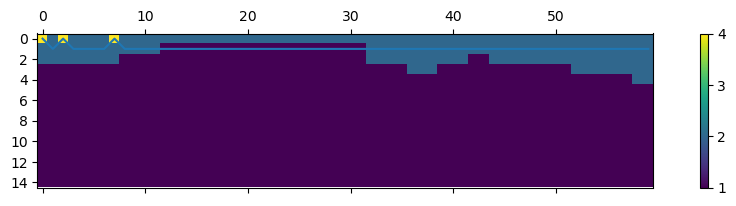

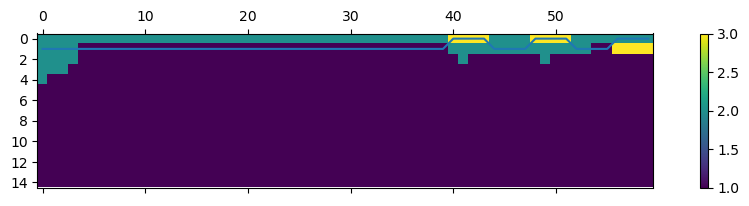

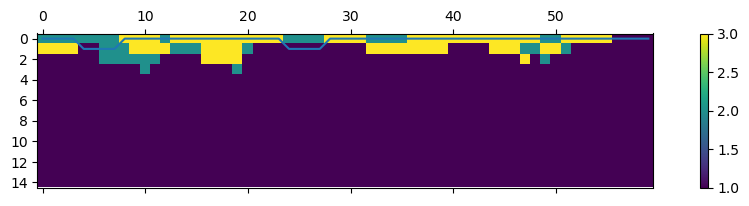

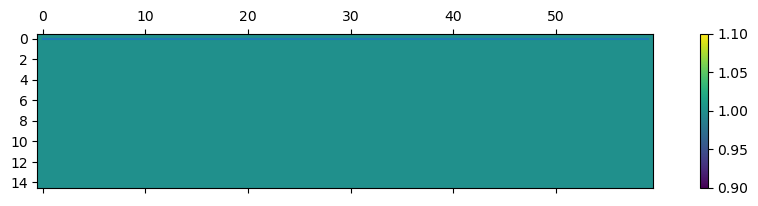

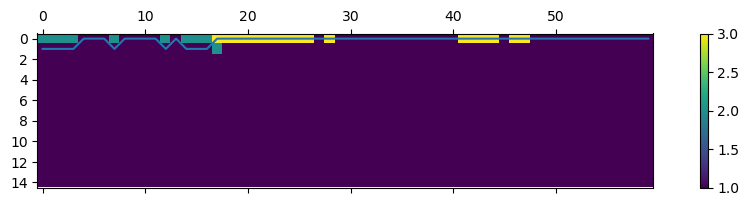

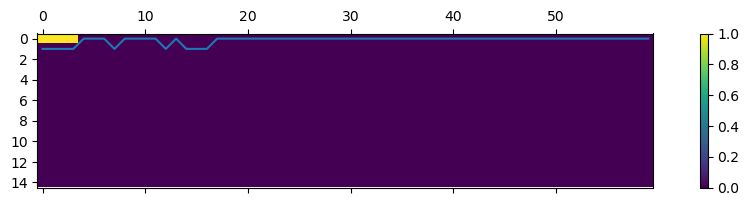

In [80]:
from caliop import Caliop_hdf_reader
import numpy as np
import matplotlib.pyplot as plt

caliop_folder = "./test_data/CALIOP/"
caliop_folder = os.path.join(caliop_folder, selected_date.strftime("%Y/%m"), )

caliop_reader = Caliop_hdf_reader()
# for file in selected_CALIOP_file_list:
filepath = os.path.join(caliop_folder, selected_CALIOP_file_list[3][0:-4] + ".hdf")
print(filepath)

caliop_long, caliop_lat = caliop_reader._get_longitude(filepath), caliop_reader._get_latitude(filepath)

# the first output variable is aerosol type, which I do not need
# feature_classification = caliop_reader._get_calipso_data(filepath, "Layer_Type")
_, feature_classification = caliop_reader._get_feature_classification(filepath, "Feature_Classification_Flags")
cloud_phase, cloud_phase_qa = caliop_reader._get_cloud_phase(filepath, "Feature_Classification_Flags")

print(np.shape(cloud_phase))

cloudy_aerosol_free_profiles_mask = np.where(np.any(feature_classification == 2, axis=0) &\
                                          ~np.any(feature_classification == 3, axis=0) &\
                                            ~np.any(feature_classification == 4, axis=0), True, False)

for i in range(5):
    fig, ax = plt.subplots(figsize=(12,2))
    pos = ax.matshow(feature_classification[:, 60 * i:60 + 60 * i])
    ax.plot(cloudy_aerosol_free_profiles_mask[60 * i:60 + 60 * i])
    fig.colorbar(pos)

# i=13
# plt.matshow(feature_classification[:, 60 * i:60 + 60 * i])
# plt.colorbar()
fig, ax = plt.subplots(figsize=(12,2))
pos = ax.matshow(cloud_phase[:, 60 * i:60 + 60 * i])
ax.plot(cloudy_aerosol_free_profiles_mask[60 * i:60 + 60 * i])
fig.colorbar(pos)

## Build CALIOP layer data DataFrame

In [154]:
import pandas as pd
import os
from caliop import Caliop_hdf_reader
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap

path_to_collocation_database = "./collocation_database/"
path_to_CALIOP_data = "./test_data/CALIOP/"
date_folder = "2017/01"
caliop_filename = "CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN"

collocation_filepath = os.path.join(path_to_collocation_database, date_folder, caliop_filename + ".csv")
caliop_data_filepath = os.path.join(path_to_CALIOP_data, date_folder, caliop_filename + ".hdf")

collocation_table = pd.read_csv(collocation_filepath)

def CALIOP_cloud_phase_to_DataFrame(caliop_data_filepath):
    reader_caliop = Caliop_hdf_reader()
    caliop_df = pd.DataFrame(columns=["long", "lat", "time", "profile_id"])
    caliop_df.long = reader_caliop._get_longitude(caliop_data_filepath)
    caliop_df.lat = reader_caliop._get_latitude(caliop_data_filepath)
    caliop_df.time = reader_caliop._get_profile_UTC(caliop_data_filepath)
    caliop_df.profile_id = reader_caliop._get_profile_id(caliop_data_filepath)
    caliop_df = caliop_df.set_index('profile_id')
    _, layer_type = reader_caliop._get_feature_classification(caliop_data_filepath, "Feature_Classification_Flags")
    caliop_df["cloudy"] = np.where(np.any(layer_type == 2, axis=0), True, False)
    # caliop_df["aerosol_free_cloud"] = np.where((~np.any(layer_type == 3, axis=0) &\
    #                                     ~np.any(layer_type == 4, axis=0)) &\
    #                                         np.any(layer_type == 2, axis=0), True, False)
    caliop_df["clear"] = np.where(np.all(layer_type == 1, axis=0), True, False)
    caliop_df["invalid"] = np.where(np.any(layer_type == 0, axis=0), True, False)
    caliop_df["aerosol"] = np.where((np.any(layer_type == 3, axis=0) |\
                                        np.any(layer_type == 4, axis=0)), True, False)
    # caliop_df["cloud_free_aerosol"] = np.where((np.any(layer_type == 3, axis=0) |\
    #                                     np.any(layer_type == 4, axis=0)) &\
    #                                         ~np.any(layer_type == 2, axis=0), True, False)

    cloud_phase_layer, cloud_phase_layer_qa = reader_caliop._get_cloud_phase(caliop_data_filepath, "Feature_Classification_Flags")

    caliop_df["water_cloud"] = np.where(np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)
    caliop_df["ice_cloud"] = np.where((np.any(cloud_phase_layer == 1, axis=0) |\
                                        np.any(cloud_phase_layer == 3, axis=0)) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0), True, False)
    caliop_df["mixed_phase"] = np.where((np.any(cloud_phase_layer == 1, axis=0) |\
                                        np.any(cloud_phase_layer == 3, axis=0)) &\
                                        np.any(cloud_phase_layer == 2, axis=0), True, False)
    caliop_df["unkown_phase"] = np.where(caliop_df["cloudy"] &\
                                        np.any(cloud_phase_layer == 0, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)

    return caliop_df

caliop_df = CALIOP_cloud_phase_to_DataFrame(caliop_data_filepath).loc[collocation_table.profile_id]

display(caliop_df.head())
print("total profiles ", len(caliop_df))
print("all clear ", sum(caliop_df.clear))
print("all invalid ", sum(caliop_df.invalid))
print("aerosol profiles ", sum(caliop_df.aerosol))
# print("cloud free aerosol profiles ", sum(caliop_df.cloud_free_aerosol))
# print("aerosol free cloud profiles ", sum(caliop_df.aerosol_free_cloud))
print("cloudy profiles ", sum(caliop_df.cloudy))
print("of which water clouds", sum(caliop_df.water_cloud))
print("or ice clouds ", sum(caliop_df.ice_cloud))
print("or mixed phase ", sum(caliop_df.mixed_phase))
print("cloudy, unknown phase ", sum(caliop_df.unkown_phase))

,long,lat,time,cloudy,clear,invalid,aerosol,water_cloud,ice_cloud,mixed_phase,unkown_phase
profile_id,,,,,,,,,,,
27210,-28.642246,72.176956,2017-01-01 13:52:35,True,False,False,True,False,True,False,False
27225,-28.713709,72.216904,2017-01-01 13:52:35,True,False,False,False,False,True,False,False
27240,-28.785179,72.256775,2017-01-01 13:52:36,True,False,False,True,False,True,False,False
27255,-28.858015,72.296562,2017-01-01 13:52:37,True,False,False,False,False,True,False,False
27270,-28.930428,72.336159,2017-01-01 13:52:38,True,False,False,False,False,True,False,False


total profiles  257
all clear  72
all invalid  0
aerosol profiles  63
cloudy profiles  160
of which water clouds 38
or ice clouds  89
or mixed phase  15
cloudy, unknown phase  18


## Compare to MODIS cloud-phase classification

/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


160


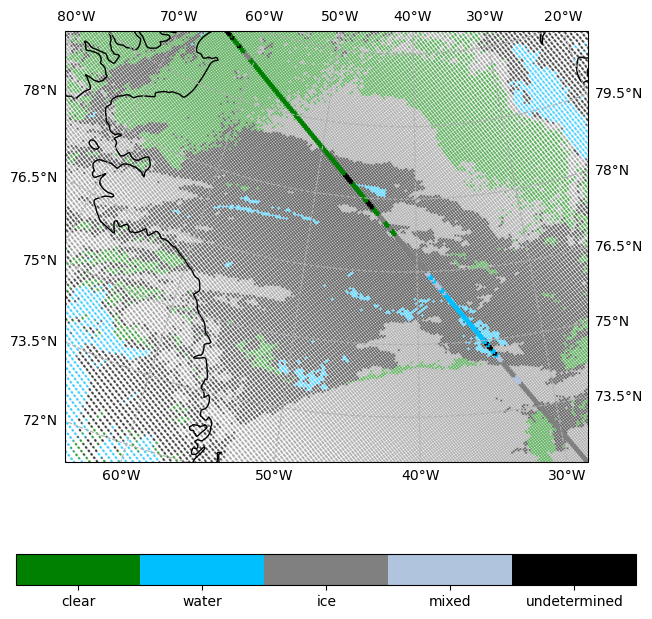

In [155]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()

invalid_data_mask = modis_cloud_phase > 6
modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_phase = np.ma.array(modis_cloud_phase, mask=invalid_data_mask)

def byte_to_label(byte):
    if byte == 6:
        return 5.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

colormap = ListedColormap(['green', 'deepskyblue', 'grey', 'lightsteelblue', 'black'])
color_array = np.where(caliop_df.water_cloud, 1, 0) + np.where(caliop_df.unkown_phase, 5, 0) +\
                np.where(caliop_df.ice_cloud, 2, 0) + np.where(caliop_df.mixed_phase, 3, 0) + 0.5

print(sum(caliop_df.water_cloud | caliop_df.ice_cloud | caliop_df.mixed_phase | caliop_df.unkown_phase))

ccrs_projection = ccrs.Orthographic(central_longitude=caliop_df.long.median(), central_latitude=caliop_df.lat.median())
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.set_extent([caliop_df.long.min(), caliop_df.long.max(), caliop_df.lat.min(), caliop_df.lat.max()])
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=2, cmap=colormap, transform=ccrs.PlateCarree(), alpha=0.5)
pos = ax.scatter(caliop_df.long, caliop_df.lat, marker='*', s=10, c=color_array, cmap=colormap, transform=ccrs.PlateCarree(), alpha=1)
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 6))
# cbar = fig.colorbar(pos, ax=ax, location="bottom")
cbar.set_ticklabels(['clear','water','ice','mixed', 'undetermined'])

fig.savefig("temp.png", dpi=500)

## Only plot collocated MODIS pixels and their phase

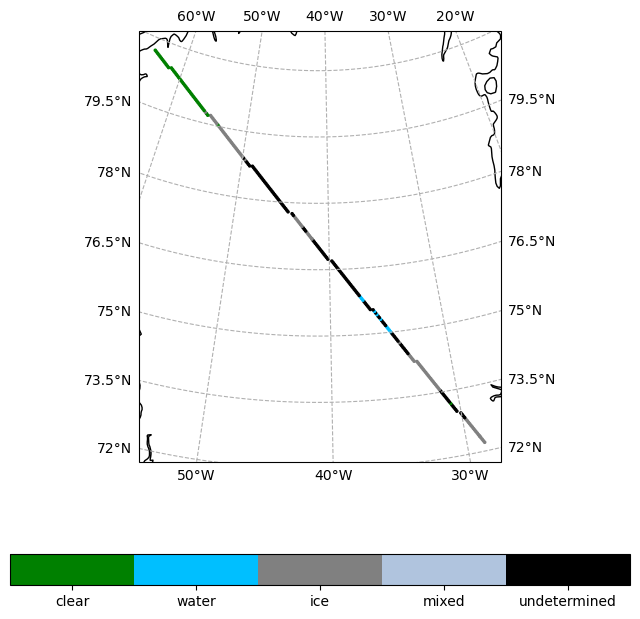

In [6]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import pandas as pd
import os
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

path_to_collocation_database = "./collocation_database/"
date_folder = "2017/01"
caliop_filename = "CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN"

collocation_filepath = os.path.join(path_to_collocation_database, date_folder, caliop_filename + ".csv")
collocation_table = pd.read_csv(collocation_filepath)

MODIS_filename = "MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_filename = "MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_filename = "MYD06_L2.A2017001.1530.061.2018029075939.hdf"
# filename_mask = collocation_table.MODIS_file == MODIS_filename
modis_collocated_indices = collocation_table.modis_idx

MODIS_path = os.path.join("./test_data/MODIS/2017/01/01/", MODIS_filename)

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()


modis_long = np.array(modis_long).flatten()[modis_collocated_indices]
modis_lat = np.array(modis_lat).flatten()[modis_collocated_indices]
modis_cloud_phase = np.array(modis_cloud_phase).flatten()[modis_collocated_indices]

modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

def byte_to_label(byte):
    if byte == 6:
        return 5.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
colormap = ListedColormap(['green', 'deepskyblue', 'grey', 'lightsteelblue', 'black'])

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=10, cmap=colormap, transform=ccrs.PlateCarree(), alpha=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 6))

cbar.set_ticklabels(['clear','water','ice','mixed', 'undetermined'])

# Compile statistics

## What is the Viewing Angle distribution?

### Sensor Zenith Angle is the variable I care about. Read it and plot it

Text(0.5, 1.0, 'Zenith Viewing Angle in MODIS image')

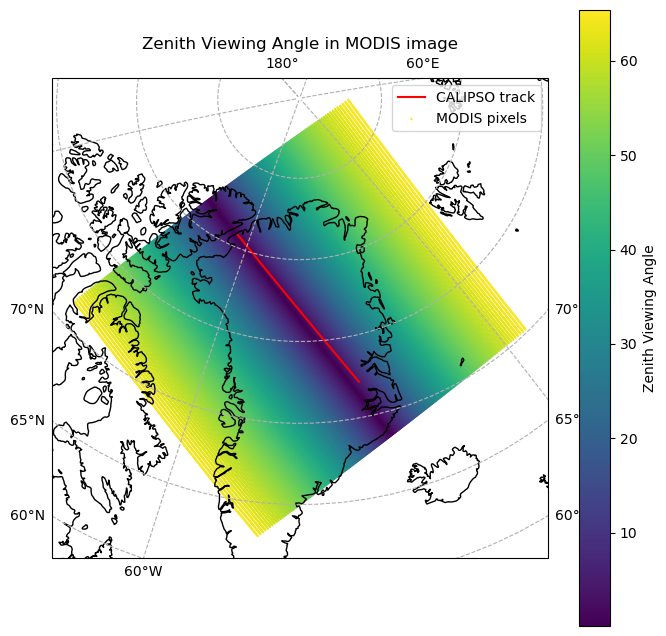

In [4]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
from caliop import Caliop_hdf_reader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

collocation_path = "./collocation_database/2017/01/CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN.csv"

collocation_table = pd.read_csv(collocation_path)
caliop_long = collocation_table.long.values
caliop_lat = collocation_table.lat.values

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
sensor_zenith_angle = MODIS_reader.select("Sensor_Zenith").get() / 100

modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.plot(caliop_long, caliop_lat, c="red", transform=ccrs.PlateCarree(), label="CALIPSO track")
pos = ax.scatter(modis_long, modis_lat, c=sensor_zenith_angle, marker='.', s=2, transform=ccrs.PlateCarree(), label="MODIS pixels")
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
ax.legend()
cbar = fig.colorbar(pos, label="Zenith Viewing Angle")
ax.set_title("Zenith Viewing Angle in MODIS image")

### Read the collocation database for January of 2017 and produce VZA distribution

252it [00:00, 912.13it/s] 


52347


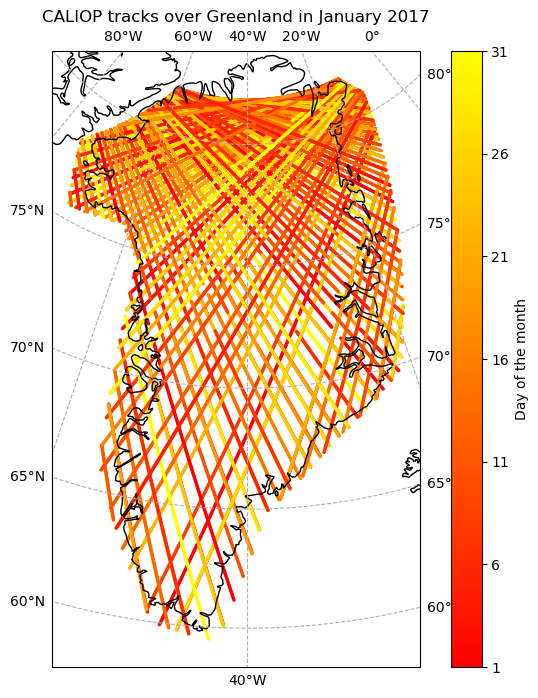

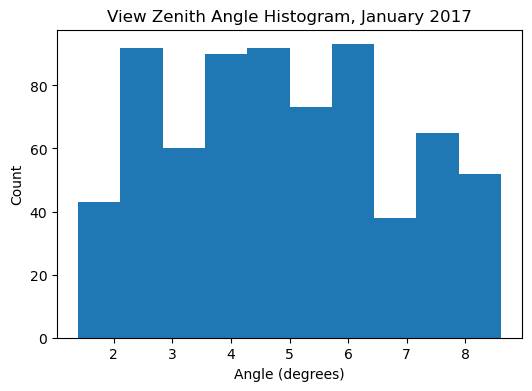

In [3]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import os
import pandas as pd
import cartopy.crs as ccrs
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import glob

# path_to_2017_collocation_database = \
#     "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/collocation_database/2017/01"
path_to_2017_collocation_database = \
    "/Users/alexandrudobra/University/MPhys/Project/collocation_testing/JASMIN_tests/hospital01/collocation_testing/collocation_database"
path_to_MODIS_folder = "./test_data/MODIS/2017/01/01/"

def get_sensor_zenith_angle(folder, collocation):
    modis_files = collocation.MODIS_file.unique()
    readers = {}
    search_strings = {}
    pixel_angles = np.full(len(collocation.index), -1)

    for modis_file in modis_files:
        search_strings[modis_file] = "*" + modis_file[9:22] + "*"

        myd06_file = glob.glob(search_strings[modis_file], root_dir=folder)
        
        if myd06_file == []:
            continue

        readers[modis_file] = SD(os.path.join(folder, myd06_file[0]))
        view_zenith_angle = np.array(readers[modis_file].select("Sensor_Zenith").get()).flatten()
        pixel_angles[collocation.MODIS_file == modis_file] = view_zenith_angle[collocation[collocation.MODIS_file == modis_file].modis_idx]

    return pixel_angles


collocation_csv_filelist = glob.glob("*.csv", root_dir=path_to_2017_collocation_database)

total_collocated_pixels = 0

ccrs_projection = ccrs.Orthographic(central_longitude=-40, central_latitude=75)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")

longs, lats = np.empty((0,)), np.empty((0,))
days = np.empty((0,))
pixel_angles = np.zeros((0,))

for file_index, file in tqdm.tqdm(enumerate(collocation_csv_filelist)):
    collocation = pd.read_csv(os.path.join(path_to_2017_collocation_database, file))
    total_collocated_pixels += len(collocation.index)

    pixel_angles = np.concatenate([pixel_angles, (get_sensor_zenith_angle(path_to_MODIS_folder, collocation))])

    days = np.concatenate((days,[date.day for date in pd.to_datetime(collocation.time)]))
    longs = np.concatenate((longs, collocation.long))
    lats = np.concatenate((lats, collocation.lat))

pos = ax.scatter(longs, lats, c=days, s=2, transform=ccrs.PlateCarree(), cmap="autumn")
fig.colorbar(pos, ticks=range(1, 32, 5), label="Day of the month")
ax.set_title("CALIOP tracks over Greenland in January 2017")

print(total_collocated_pixels)

pixel_angles = pixel_angles[pixel_angles != -1] / 100
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(pixel_angles)
ax.set_title("View Zenith Angle Histogram, January 2017")
ax.set_xlabel("Angle (degrees)")
ax.set_ylabel("Count")
fig.savefig("view_zenith_angle_histogram_2017_01.png", dpi=200)

## Produce cloud cover and phase statistics

### Test reading in collocation files

In [216]:
import os
import glob
import numpy as np
import pandas as pd

def get_caliop_id_from_filename(filename):
    return filename[-21:-2]

def merge_collocation_data(folder_path):
    if not os.path.isdir(folder_path):
        raise ValueError("The provided path is not a valid directory.")

    # recursively find all files in this directory that match the pattern \-dd\Tdd\- (to make sure we are not reading other csvs)
    collocation_files = glob.glob("**/*-[0-9][0-9]T[0-9][0-9]-*.csv", root_dir=folder_path, recursive=True)

    dataframes = []

    for file in collocation_files:
        file_path = os.path.join(folder_path, file)
        with open(file_path) as f:
            start_and_end_times = f.readline()
            # make a dictionary so the file number can be replaced with the string
            modis_search_strings = {i: file for (i, file) in enumerate(f.readline().split(' ')[:-1])}
        
        df = pd.read_csv(file_path, header=2).rename(columns={"MODIS_file": "mFileID", "modis_idx": "pixel_id"})
        df.mFileID = np.vectorize(modis_search_strings.get)(df.mFileID.values)
        caliop_id = get_caliop_id_from_filename(os.path.basename(file_path)[:-4])
        df["cFileID"] = [caliop_id] * len(df.profile_id.values)

        dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True)

# Example usage:
# folder_path = "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/JASMIN_tests/10Jan/collocation_database"

folder_path = "./collocation_database/"

merged_df = merge_collocation_data(folder_path)#.set_index("profile_id")
print(len(merged_df))

display(merged_df.head())

merged_df.to_csv("merged_df_test.csv", index=False)

1130


,profile_id,pixel_id,mFileID,cFileID
0,89925,63860,A2017001.0540,2017-01-01T05-38-12
1,89940,64130,A2017001.0540,2017-01-01T05-38-12
2,89955,64400,A2017001.0540,2017-01-01T05-38-12
3,89970,64670,A2017001.0540,2017-01-01T05-38-12
4,89985,64940,A2017001.0540,2017-01-01T05-38-12


### Add CALIOP cloud features to the merged collocation data

In [217]:
import pandas as pd
import glob
import os

def get_caliop_id_from_filename(filename):
    return filename[-21:-2]

def get_caliop_cloud_phase(caliop_filepath):
    from caliop import Caliop_hdf_reader
    reader_caliop = Caliop_hdf_reader()
    caliop_df = pd.DataFrame(columns=["profile_id"])
    caliop_df.profile_id = reader_caliop._get_profile_id(caliop_filepath)
    caliop_df = caliop_df.set_index('profile_id')

    _, layer_type = reader_caliop._get_feature_classification(caliop_filepath, "Feature_Classification_Flags")
    caliop_df["cCloudy"] = np.where(np.any(layer_type == 2, axis=0), True, False)
    caliop_df["cClear"] = np.where(np.all(layer_type == 1, axis=0), True, False)
    caliop_df["cInvalid"] = np.where(np.any(layer_type == 0, axis=0), True, False)
    caliop_df["cAerosol"] = np.where((np.any(layer_type == 3, axis=0) |\
                                        np.any(layer_type == 4, axis=0)), True, False)

    cloud_phase_layer, cloud_phase_layer_qa = reader_caliop._get_cloud_phase(caliop_filepath, "Feature_Classification_Flags")

    caliop_df["cWater"] = np.where(np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)
    caliop_df["cIce"] = np.where((np.any(cloud_phase_layer == 1, axis=0) |\
                                        np.any(cloud_phase_layer == 3, axis=0)) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0), True, False)
    caliop_df["cUnknown"] = np.where(caliop_df["cCloudy"] &\
                                        np.any(cloud_phase_layer == 0, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)
    caliop_df["cPhaseHighQA"] = np.where(np.any(cloud_phase_layer_qa == 3, axis=0), True, False)

    return caliop_df

caliop_data_folder = "./test_data/CALIOP"
caliop_product = "MLay"
merged_collocation = pd.read_csv("./merged_df_test.csv")

collocated_cloud_phase_dataframes = []

for caliop_file_id in merged_collocation.cFileID.unique():
    caliop_filepath = glob.glob(f"**/*{caliop_product}*{caliop_file_id}*", root_dir=caliop_data_folder, recursive=True)

    if len(caliop_filepath) == 0:
        print(caliop_file_id, "file not found")
        raise Exception

    caliop_filepath = os.path.join(caliop_data_folder, caliop_filepath[0])
    df = get_caliop_cloud_phase(caliop_filepath)

    # reduce to collocated profiles
    df = df.loc[merged_collocation.profile_id[merged_collocation.cFileID == caliop_file_id], :]

    # add the caliop file id to uniquely identify each profile
    df["cFileID"] = [caliop_file_id] * len(df)

    df.reset_index()
    df.set_index(["cFileID"], append=True, inplace=True)

    collocated_cloud_phase_dataframes.append(df)

merged_collocated_caliop_cloud_phase_df = pd.concat(collocated_cloud_phase_dataframes)
print(len(merged_collocated_caliop_cloud_phase_df))
merged_collocated_caliop_cloud_phase_df.head()


1130


,,cCloudy,cClear,cInvalid,cAerosol,cWater,cIce,cUnknown,cPhaseHighQA
profile_id,cFileID,,,,,,,,
89925,2017-01-01T05-38-12,False,False,False,True,False,False,False,False
89940,2017-01-01T05-38-12,False,False,False,True,False,False,False,False
89955,2017-01-01T05-38-12,False,True,False,False,False,False,False,False
89970,2017-01-01T05-38-12,False,True,False,False,False,False,False,False
89985,2017-01-01T05-38-12,False,True,False,False,False,False,False,False


In [203]:
merged_collocated_caliop_cloud_phase_df.index.get_level_values(1).unique()

Index(['2017-01-01T05-38-12', '-01T15-31-33ZN_Subs', '-01T14-38-58ZD_Subs',
       '2017-01-01T13-52-38'],
      dtype='object', name='cFileID')

### Add MODIS features to the merged collocation

#### Where is the phase information?
The best phase data is found in `Cloud_Phase_Infrared_1km` and `Cloud_Phase_Optical_Properties` (for daytime pixels only). Both are 1km so they will have to be downsampled.

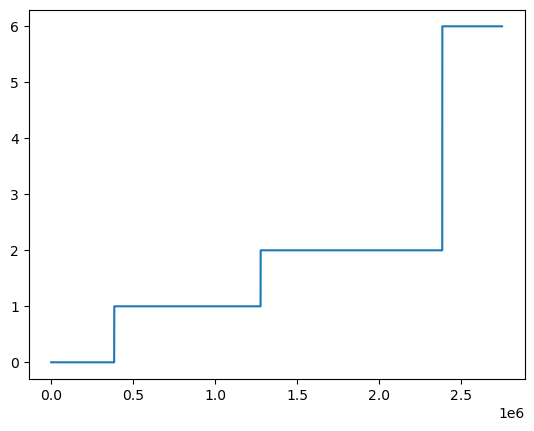

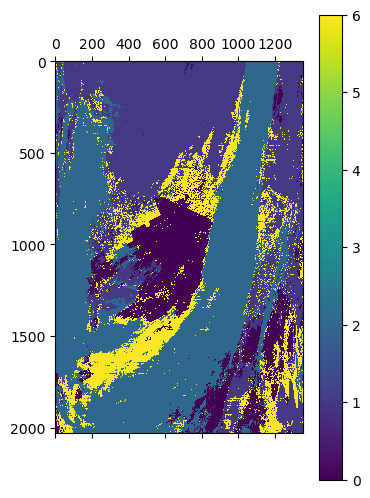

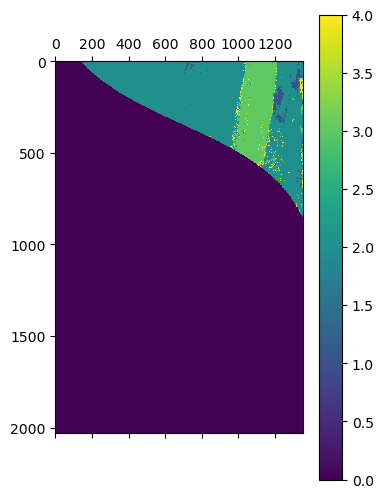

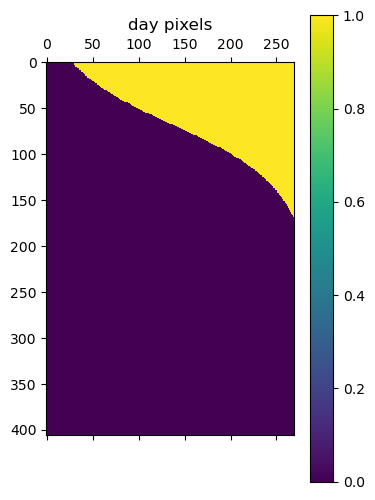

In [143]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import numpy as np

modis_filepath = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"

# def get_modis_cloud_phase_to_df(modis_filepath):
MODIS_reader = SD(modis_filepath)
modis_cloud_mask_1km = MODIS_reader.select("Cloud_Mask_1km").get()[:,:,0]

def vectorized_parse_byte_properties(byte_array):
    # Vectorized version of parse_byte_properties function
    properties = {}

    # Bit 0: Cloud Mask Flag
    properties['Cloud Mask Flag'] = np.where((byte_array & 0b1) == 0, 'Not determined', 'Determined')

    # Bits 2-1: Unobstructed FOV Quality Flag
    quality_flag = (byte_array >> 1) & 0b11
    quality_mapping = {
        0b00: 'Cloudy',
        0b01: 'Uncertain',
        0b10: 'Probably Clear',
        0b11: 'Confident Clear'
    }
    properties['Unobstructed FOV Quality Flag'] = np.vectorize(quality_mapping.get)(quality_flag)

    # Bit 3: Day or Night Path
    properties['Day or Night Path'] = np.where((byte_array >> 2) & 0b1 == 0, 'Night', 'Day')

    # Bit 4: Sunglint Path
    properties['Sunglint Path'] = np.where((byte_array >> 3) & 0b1 == 0, 'Yes', 'No')

    # Bit 5: Snow/Ice Background Path
    properties['Snow/Ice Background Path'] = np.where((byte_array >> 4) & 0b1 == 0, 'Yes', 'No')

    # Bits 7-6: Land or Water Path
    land_water_flag = (byte_array >> 5) & 0b11
    land_water_mapping = {
        0b00: 'Water',
        0b01: 'Coastal',
        0b10: 'Desert',
        0b11: 'Land'
    }
    properties['Land or Water Path'] = np.vectorize(land_water_mapping.get)(land_water_flag)

    return properties

# Example usage with a NumPy array of bytes
byte_array = np.array(modis_cloud_mask_1km, dtype=np.uint8).flatten()
result = vectorized_parse_byte_properties(byte_array)

solar_zenith = MODIS_reader.select("Solar_Zenith").get()
daytime_pixels = solar_zenith < 8136

modis_infrared_phase = MODIS_reader.select("Cloud_Phase_Infrared_1km").get()
modis_optical_phase = MODIS_reader.select("Cloud_Phase_Optical_Properties").get()

infrared_fillvalue = MODIS_reader.select("Cloud_Phase_Infrared_1km").attributes().get("_FillValue")
optical_fillvalue = MODIS_reader.select("Cloud_Phase_Optical_Properties").attributes().get("_FillValue")

modis_infrared_phase = np.where(modis_infrared_phase == infrared_fillvalue, 6, modis_infrared_phase)

plt.plot(np.sort(modis_infrared_phase.flatten()))
plt.matshow(modis_infrared_phase)
plt.colorbar()
plt.matshow(modis_optical_phase)
plt.colorbar()
plt.matshow(daytime_pixels)
plt.gca().set_title("day pixels")
plt.colorbar()


#### Compare the 1km IR cloud-phase product to the version downsampled to 5km and to the 5km IR cloud-phase product

The downsampled version is better.

In [ ]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

def downsample_2d_array_vectorized(input_array, fill_value):
    # Convert the input array to a NumPy array
    input_np = np.array(input_array)
    
    # Get the dimensions of the input array
    rows, cols = input_np.shape
    
    from math import floor

    # Check if the array dimensions are divisible by 5
    rows, cols = floor(rows/5) * 5, floor(cols/5) * 5
    input_np = input_np[:rows, :cols]
    
    # Reshape the input array into 5x5 chunks
    reshaped_array = input_np.reshape(rows//5, 5, cols//5, 5).transpose((0, 2, 1, 3)).reshape(rows//5, cols//5, 25)
    
    # Check if each 5x5 chunk has the same value
    repeated_tiles = np.tile(reshaped_array[:,:,0][:,:,np.newaxis], 25)
    unique_values = np.all(reshaped_array == repeated_tiles, axis=2)
    
    # Create the output array with the appropriate fill values
    output_array = np.where(unique_values, reshaped_array[:, :, 0], fill_value)
    
    return output_array

def downsample_array_voting(input_array, fillvalue, pixelXsize=5, pixelYsize=5, threshold=20):
    input_array = np.array(input_array)
    rows, cols = input_array.shape
    
    # reduce array to reshapeable size
    rows, cols = rows//pixelXsize * pixelXsize, cols//pixelYsize * pixelYsize
    input_array = input_array[:rows, :cols]

    # the dimensions of the output array
    rows, cols = rows//pixelXsize, cols//pixelYsize
    
    # Reshape the input array into 5x5 chunks
    reshaped_array = input_array.reshape(rows, pixelXsize, cols, pixelYsize).transpose((0, 2, 1, 3)).reshape(rows, cols, pixelXsize*pixelYsize)

    def find_element_above_threshold(arr, threshold, fillvalue):
        unique_elements, element_counts = np.unique(arr, return_counts=True)
        above_threshold_indices = np.nonzero(element_counts >= threshold)[0]

        if above_threshold_indices.size > 0:
            return unique_elements[above_threshold_indices[0]]
        else:
            return fillvalue
    
    output_array = np.apply_along_axis(lambda x: find_element_above_threshold(x, threshold, fillvalue), axis=2, arr=reshaped_array)

    return output_array

def downsample_array_by_mode(input_array, pixelXsize=5, pixelYsize=5):
    input_array = np.array(input_array)
    rows, cols = input_array.shape
    
    # reduce array to reshapeable size
    rows, cols = rows//pixelXsize * pixelXsize, cols//pixelYsize * pixelYsize
    input_array = input_array[:rows, :cols]

    # the dimensions of the output array
    rows, cols = rows//pixelXsize, cols//pixelYsize
    
    # reshape to 3d array where each axb pixel contains an array of a*b subpixels
    reshaped_array = input_array.reshape(rows, pixelXsize, cols, pixelYsize).transpose((0, 2, 1, 3)).reshape(rows, cols, pixelXsize*pixelYsize)

    # output_array = mode(reshaped_array, axis=2, keepdims=True)[0]
    output_array = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=2, arr=reshaped_array)

    return output_array

modis_filepath = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"

# def get_modis_cloud_phase_to_df(modis_filepath):
MODIS_reader = SD(modis_filepath)

modis_infrared_phase_5km = MODIS_reader.select("Cloud_Phase_Infrared").get()
modis_infrared_phase_5km = np.where(modis_infrared_phase_5km == 127, 3, 
modis_infrared_phase_5km)
modis_infrared_phase_5km = np.where(modis_infrared_phase_5km == 6, 3, modis_infrared_phase_5km)

modis_infrared_phase = MODIS_reader.select("Cloud_Phase_Infrared_1km").get()
modis_infrared_phase = np.where(modis_infrared_phase == 127, 3, modis_infrared_phase)
modis_infrared_phase = np.where(modis_infrared_phase == 6, 3, modis_infrared_phase)

downsampled_test = downsample_array_by_mode(modis_infrared_phase)

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(modis_infrared_phase)
ax.set_title("1km infrared phase")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Clear', 'Water', 'Ice', 'Undetermined'])

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(downsampled_test)
ax.set_title("downsampled to 5km by mode")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Clear', 'Water', 'Ice', 'Undetermined'])

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(modis_infrared_phase_5km)
ax.set_title("5km infrared phase")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Clear', 'Water', 'Ice', 'Undetermined'])

#### Compare the 1km cloud-mask product to the version downsampled to 5km and to the 5km cloud-mask product

The 5km version is better than the downsampled one. This means improvements can be made to the downsampling algorithm.

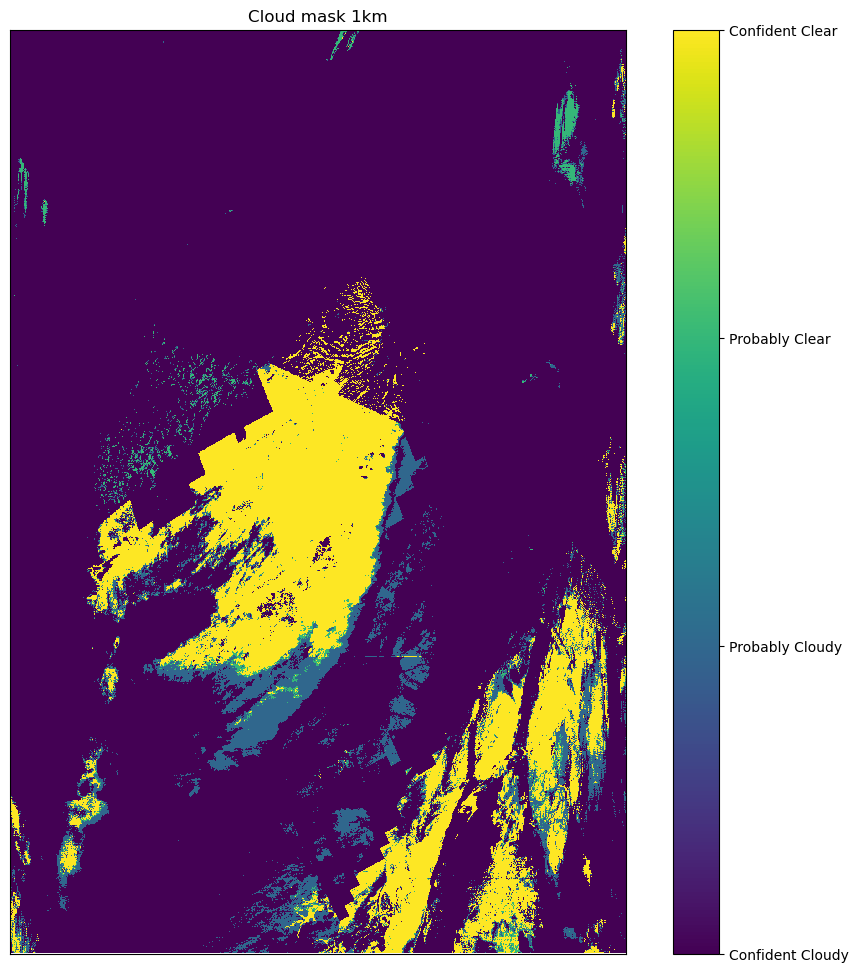

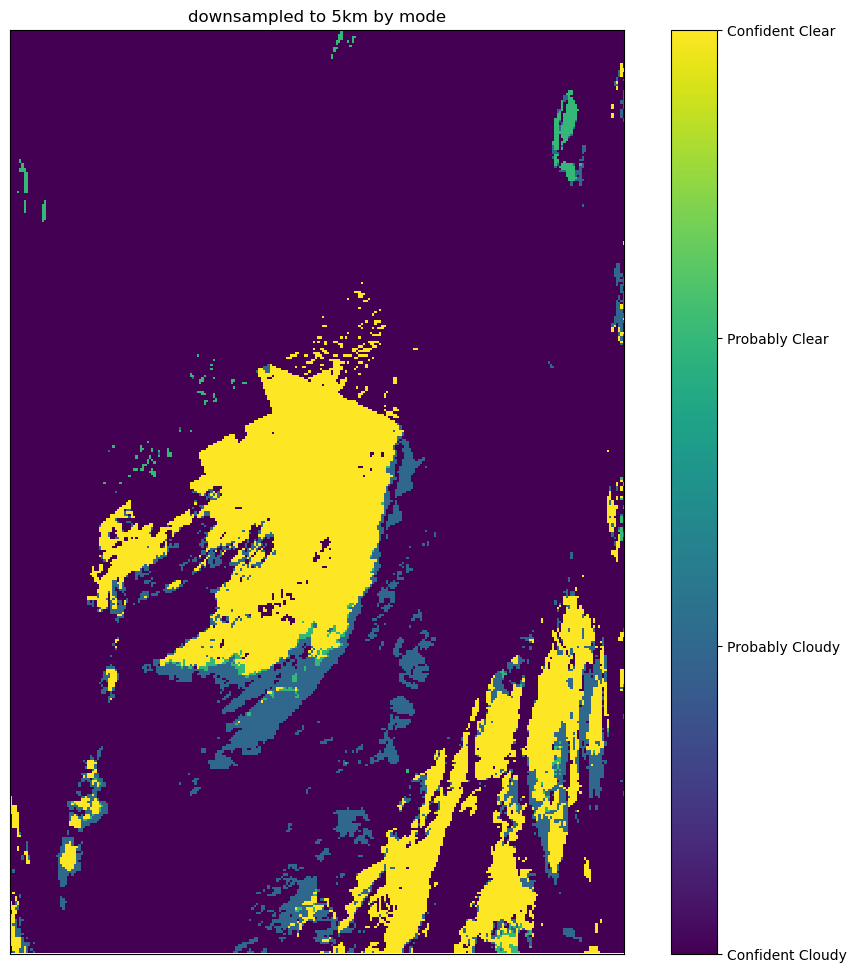

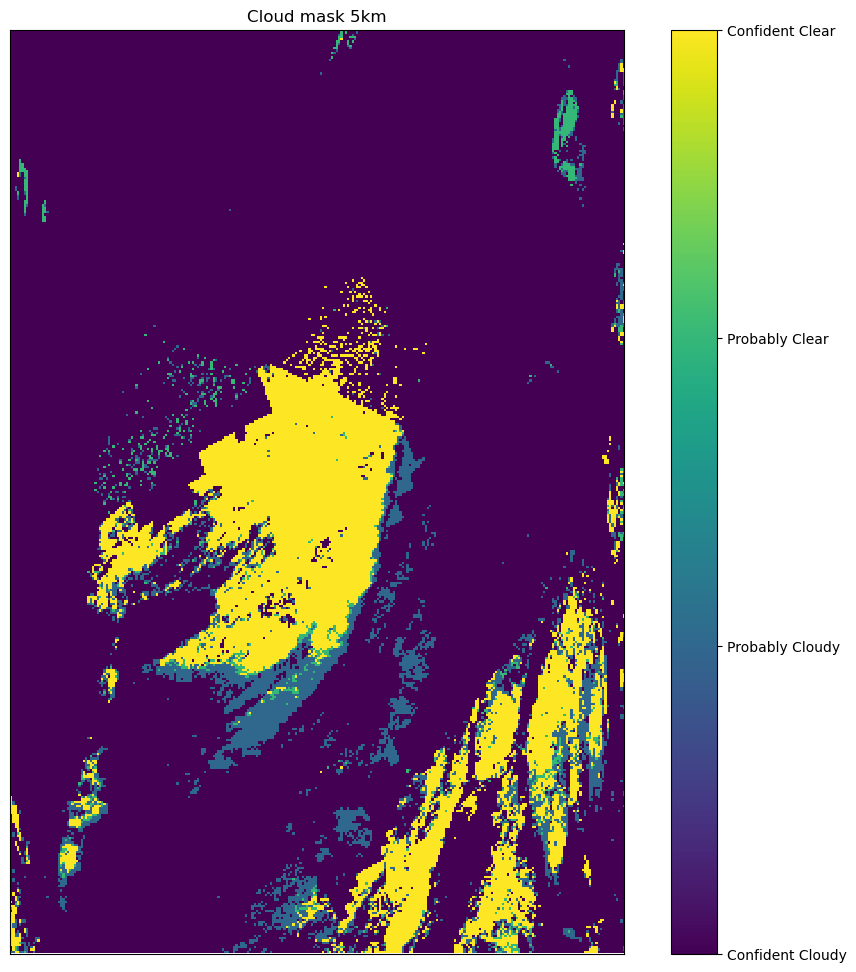

In [148]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

def downsample_array_by_mode(input_array, pixelXsize=5, pixelYsize=5):
    input_array = np.array(input_array)
    rows, cols = input_array.shape
    
    # reduce array to reshapeable size
    rows, cols = rows//pixelXsize * pixelXsize, cols//pixelYsize * pixelYsize
    input_array = input_array[:rows, :cols]

    # the dimensions of the output array
    rows, cols = rows//pixelXsize, cols//pixelYsize
    
    # reshape to 3d array where each axb pixel contains an array of a*b subpixels
    reshaped_array = input_array.reshape(rows, pixelXsize, cols, pixelYsize).transpose((0, 2, 1, 3)).reshape(rows, cols, pixelXsize*pixelYsize)

    # output_array = mode(reshaped_array, axis=2, keepdims=True)[0]
    output_array = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=2, arr=reshaped_array)

    return output_array

def get_cloudiness_flag(byte_array):
    # Bits 2-1: Unobstructed FOV Quality Flag
    quality_flag = (byte_array >> 1) & 0b11
    quality_mapping = {
        0b00: 0,
        0b01: 1,
        0b10: 2,
        0b11: 3
    }

    return np.vectorize(quality_mapping.get)(quality_flag)

modis_filepath = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"

# def get_modis_cloud_phase_to_df(modis_filepath):
MODIS_reader = SD(modis_filepath)

cloud_mask_5km = get_cloudiness_flag(MODIS_reader.select("Cloud_Mask_5km").get()[:,:,0])

cloud_mask_1km = get_cloudiness_flag(MODIS_reader.select("Cloud_Mask_1km").get()[:,:,0])

downsampled_test = downsample_array_by_mode(cloud_mask_1km)

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(cloud_mask_1km)
ax.set_title("Cloud mask 1km")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Confident Cloudy', 'Probably Cloudy', 'Probably Clear', 'Confident Clear'])

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(downsampled_test)
ax.set_title("downsampled to 5km by mode")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Confident Cloudy', 'Probably Cloudy', 'Probably Clear', 'Confident Clear'])

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(cloud_mask_5km)
ax.set_title("Cloud mask 5km")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Confident Cloudy', 'Probably Cloudy', 'Probably Clear', 'Confident Clear'])


#### Get MODIS cloud information into a dataframe

In [214]:
from pyhdf.SD import *
import pandas as pd
import glob
import os

def downsample_array_by_mode(input_array, pixelXsize=5, pixelYsize=5):
    input_array = np.array(input_array)
    rows, cols = input_array.shape
    
    # reduce array to reshapeable size
    rows, cols = rows//pixelXsize * pixelXsize, cols//pixelYsize * pixelYsize
    input_array = input_array[:rows, :cols]

    # the dimensions of the output array
    rows, cols = rows//pixelXsize, cols//pixelYsize
    
    # reshape to 3d array where each axb pixel contains an array of a*b subpixels
    reshaped_array = input_array.reshape(rows, pixelXsize, cols, pixelYsize).transpose((0, 2, 1, 3)).reshape(rows, cols, pixelXsize*pixelYsize)

    # output_array = scipy.stats.mode(reshaped_array, axis=2, keepdims=True)[0]
    output_array = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=2, arr=reshaped_array)

    return output_array

def get_modis_5km_cloud_phase(modis_filepath, daytime_only=False):
    if not os.path.exists(modis_filepath):
        print("The given MODIS file does not exist.")
        return

    df = pd.DataFrame(columns=["pixel_id", "mCloudy", "mClear", "mWater", "mIce", "mUndetermined"])

    reader = SD(modis_filepath)
    if not daytime_only:
        phase_1km  = reader.select("Cloud_Phase_Infrared_1km").get()
        fill_value = reader.select("Cloud_Phase_Infrared_1km").attributes().get("_FillValue")
        phase_1km = np.where((phase_1km == fill_value) | (phase_1km == 6), 3, phase_1km)
    else:
        phase_1km  = reader.select("Cloud_Phase_Optical_Properties").get()
        fill_value = reader.select("Cloud_Phase_Optical_Properties").attributes().get("_FillValue")
        phase_1km = np.where(phase_1km == fill_value, 5, phase_1km)
        phase_1km -= 1

    phase_downsampled = downsample_array_by_mode(phase_1km, pixelXsize=5, pixelYsize=5).flatten()

    df["pixel_id"] = np.arange(len(phase_downsampled))
    df.set_index("pixel_id", inplace=True)
    df["mClear"] = phase_downsampled == 0
    df["mWater"] = phase_downsampled == 1
    df["mIce"] = phase_downsampled == 2
    df["mUndetermined"] = phase_downsampled == 3
    # df["mInfraredAlg"] = [True] * len(df)

    if daytime_only:
        df = df[phase_downsampled != 4]
        # df["mInfraredAlg"] = [False] * len(df)

    # should I set the cloudy flags according to the mask or according to the phase product?
    # cloud_mask_quality_flag = (MODIS_reader.select("Cloud_Mask_5km").get()[:,:,0] >> 1) & 0b11
    # df["mCloudy"] = (np.array(cloud_mask_quality_flag).flatten() == 0) | (np.array(cloud_mask_quality_flag).flatten() == 1)

    df["mCloudy"] = df["mWater"] | df["mIce"] | df["mUndetermined"]

    return df

modis_data_folder = "./test_data/MODIS"
modis_product = "MYD06"
merged_collocation = pd.read_csv("./merged_df_test.csv")

collocated_cloud_phase_dataframes = []

for modis_file_id in merged_collocation.mFileID.unique():
    modis_filepath = glob.glob(f"**/*{modis_product}*{modis_file_id}*", root_dir=modis_data_folder, recursive=True)

    if len(modis_filepath) == 0:
        print(modis_file_id, "file not found")
        raise Exception

    modis_filepath = os.path.join(modis_data_folder, modis_filepath[0])
    df = get_modis_5km_cloud_phase(modis_filepath)

    if df.empty:
        continue

    # reduce to collocated pixels
    collocated_pixel_ids_in_file = merged_collocation.pixel_id[merged_collocation.mFileID == modis_file_id]
    df = df.loc[np.intersect1d(collocated_pixel_ids_in_file.values, df.index.values), :]

    # add the modis file id to uniquely identify each pixel
    df["mFileID"] = [modis_file_id] * len(df)

    df.reset_index()
    df.set_index(["mFileID"], append=True, inplace=True)

    collocated_cloud_phase_dataframes.append(df)

modis_cloud_df = pd.concat(collocated_cloud_phase_dataframes)

print(len(modis_cloud_df))

modis_cloud_df.head()

# modis_filepath = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"

# df = get_modis_5km_cloud_phase_to_df(modis_filepath, daytime_only=True)

display(modis_cloud_df.head(20))
print("total pixels", len(modis_cloud_df))
print("cloudy pixels", sum(modis_cloud_df.mCloudy))
print("clear sky", sum(modis_cloud_df.mClear))
print("water cloud", sum(modis_cloud_df.mWater))
print("ice cloud", sum(modis_cloud_df.mIce))
print("undetermined phase", sum(modis_cloud_df.mUndetermined))
print("water + ice + undetermined", sum(modis_cloud_df.mWater) + sum(modis_cloud_df.mIce) + sum(modis_cloud_df.mUndetermined))

# plt.plot(np.sort(df.index.values))

1120


,,mCloudy,mClear,mWater,mIce,mUndetermined
pixel_id,mFileID,,,,,
63860,A2017001.0540,False,True,False,False,False
64130,A2017001.0540,False,True,False,False,False
64400,A2017001.0540,False,True,False,False,False
64670,A2017001.0540,False,True,False,False,False
64940,A2017001.0540,False,True,False,False,False
65210,A2017001.0540,False,True,False,False,False
65480,A2017001.0540,False,True,False,False,False
65750,A2017001.0540,False,True,False,False,False
66020,A2017001.0540,False,True,False,False,False


total pixels 1120
cloudy pixels 824
clear sky 296
water cloud 18
ice cloud 582
undetermined phase 224
water + ice + undetermined 824


### Function that extracts sets of features given the merged collocation dataset

In [227]:
from pyhdf.SD import *
import pandas as pd
import glob
import os

def get_modis_5km_optical_cloud_phase(modis_filepath):
    return get_modis_5km_cloud_phase(modis_filepath, daytime_only=True)

def get_feature_sets(feature_set, data_folder, collocated_file_ids, collocated_profile_ids):
    # parameter validation
    existing_feature_sets = ["modis_infrared_cloud_phase", "modis_optical_cloud_phase", "caliop_cloud_phase"]
    existing_feature_set_extractor_functions = [get_modis_5km_cloud_phase, get_modis_5km_optical_cloud_phase, get_caliop_cloud_phase]
    corresponding_product_names = ["MYD06", "MYD06", "CAL_LID_L2_05kmMLay-Standard-V4-51"]

    feature_set_extractor_func_dict = dict(zip(existing_feature_sets, existing_feature_set_extractor_functions))
    product_name_dict = dict(zip(existing_feature_sets, corresponding_product_names))

    if feature_set not in existing_feature_sets:
        print(f"{feature_set} not in the existing feature set extractor functions. The parameter feature_set should be one of the following:")
        print(", ".join(existing_feature_sets))
        return

    if not os.path.exists(data_folder):
        print(f"The data folder given does not exist.")
        return
    
    collocated_data_df_list = []

    # loop over unique file ids
    for file_id in set(collocated_file_ids):
        file_path = glob.glob(f"**/*{product_name_dict[feature_set]}*{file_id}*", root_dir=data_folder, recursive=True)

        if len(file_path) == 0:
            print(file_id, "file not found")
            raise Exception
        
        file_path = os.path.join(data_folder, file_path[0])
        
        # call the desired function
        df = feature_set_extractor_func_dict[feature_set](file_path)

        if df.empty:
            continue

        # reduce to collocated pixels
        collocated_profile_ids_in_file = collocated_profile_ids[collocated_file_ids == file_id]
        df = df.loc[np.intersect1d(collocated_profile_ids_in_file, df.index.values), :]

        # add the file id to uniquely identify each profile
        df["fileID"] = [file_id] * len(df)

        df.reset_index()
        df.set_index(["fileID"], append=True, inplace=True)

        collocated_data_df_list.append(df)

    return pd.concat(collocated_data_df_list)
    
test_no = 3
merged_collocation = pd.read_csv("./merged_df_test.csv")

feature_sets = ["modis_infrared_cloud_phase", "modis_optical_cloud_phase", "caliop_cloud_phase", "caliop_cloud_phase"]
data_folders = ["./test_data/MODIS", "./test_data/MODIS", "./test_data/CALIOP", "./test_data/MOI"]
fileID_keys = ["mFileID", "mFileID", "cFileID", "cFileID"]
profileID_keys = ["pixel_id", "pixel_id", "profile_id", "profile_id"]

collocated_file_ids = merged_collocation[fileID_keys[test_no]]
collocated_profile_ids = merged_collocation[profileID_keys[test_no]]

df = get_feature_sets(feature_sets[test_no], data_folders[test_no], collocated_file_ids, collocated_profile_ids)
print(len(df))
df.head(20)


The data folder given does not exist.


TypeError: object of type 'NoneType' has no len()

### Extract cloud-phase information from both satellites and compare

#### Read in features

In [1]:
import os
import numpy as np
import pandas as pd
from get_feature_sets import get_feature_sets

modis_infrared_phase = get_feature_sets("modis_infrared_cloud_phase", "./test_data/MODIS/", "./merged_df_test.csv")
caliop_phase = get_feature_sets("caliop_cloud_phase", "./test_data/CALIOP/", "./merged_df_test.csv")

display(modis_infrared_phase.info())
display(caliop_phase.info())


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1130 entries, (23074, 'A2017001.1350') to (46569, 'A2017001.1530')
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   mCloudy        1130 non-null   bool 
 1   mClear         1130 non-null   bool 
 2   mWater         1130 non-null   bool 
 3   mIce           1130 non-null   bool 
 4   mUndetermined  1130 non-null   bool 
dtypes: bool(5)
memory usage: 50.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1130 entries, (37935, '-01T15-31-33ZN_Subs') to (146625, '-01T14-38-58ZD_Subs')
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   cCloudy       1130 non-null   bool 
 1   cClear        1130 non-null   bool 
 2   cInvalid      1130 non-null   bool 
 3   cAerosol      1130 non-null   bool 
 4   cWater        1130 non-null   bool 
 5   cIce          1130 non-null   bool 
 6   cUnknown      1130 non-null   bool 
 7   cPhaseHighQA  1130 non-null   bool 
dtypes: bool(8)
memory usage: 41.2+ KB


None

#### Print some stats

In [5]:
print("total profiles", len(caliop_phase))

print("CALIOP cloudy MODIS cloudy", sum(caliop_phase.cCloudy.values & modis_infrared_phase.mCloudy.values) / sum(caliop_phase.cCloudy.values))
print("CALIOP cloudy MODIS clear", sum(caliop_phase.cCloudy.values & modis_infrared_phase.mClear.values) / sum(caliop_phase.cCloudy.values))
print("CALIOP clear MODIS cloudy", sum(caliop_phase.cClear.values & modis_infrared_phase.mCloudy.values) / sum(caliop_phase.cClear.values))
print("CALIOP clear MODIS clear", sum(caliop_phase.cClear.values & modis_infrared_phase.mClear.values) / sum(caliop_phase.cClear.values))

print("CALIOP water MODIS water", sum(caliop_phase.cWater.values & modis_infrared_phase.mWater.values) / sum(caliop_phase.cWater.values))
print("CALIOP water MODIS ice", sum(caliop_phase.cWater.values & modis_infrared_phase.mIce.values) / sum(caliop_phase.cWater.values))
print("CALIOP ice MODIS water", sum(caliop_phase.cIce.values & modis_infrared_phase.mWater.values) / sum(caliop_phase.cIce.values))
print("CALIOP ice MODIS ice", sum(caliop_phase.cIce.values & modis_infrared_phase.mIce.values) / sum(caliop_phase.cIce.values))

total profiles 1130
CALIOP cloudy MODIS cloudy 0.7350157728706624
CALIOP cloudy MODIS clear 0.26498422712933756
CALIOP clear MODIS cloudy 0.752
CALIOP clear MODIS clear 0.248
CALIOP water MODIS water 0.02631578947368421
CALIOP water MODIS ice 0.5131578947368421
CALIOP ice MODIS water 0.01195814648729447
CALIOP ice MODIS ice 0.4962630792227205
